In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as Data

dtype = torch.float32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

文本预处理

In [3]:
sentences = ["jack like dog", "jack like cat", "jack like animal",
  "dog cat animal", "banana apple cat dog like", "dog fish milk like",
  "dog cat animal like", "jack like apple", "apple like", "jack like banana",
  "apple banana jack movie book music like", "cat dog hate", "cat dog like"]

word_sequence = " ".join(sentences).split() # ['jack', 'like', 'dog', 'jack', 'like', 'cat', 'animal',...]
vocab = list(set(word_sequence)) # build words vocabulary
word2idx = {w: i for i, w in enumerate(vocab)} # {'jack':0, 'like':1,...}

word2vec模型参数

In [4]:
batch_size = 8
embedding_size = 2  # 2 dim vector represent one word
C = 2 # window size
voc_size = len(vocab) # 词表大小

In [5]:
skip_grams = []
for idx in range(C, len(word_sequence) - C):
    center = word2idx[word_sequence[idx]]
    context_idx = list(range(idx - C, idx)) + list(range(idx + 1, idx + C + 1)) # context word idx
    context = [word2idx[word_sequence[i]] for i in context_idx]
    for w in context:
        skip_grams.append([center, w])

In [12]:
def make_data(datas, voc_size):
    one_hot = np.eye(voc_size)
    datas = np.asarray(datas)
    input_data = one_hot[datas[:, 0]]
    output_data = datas[:, 1]
    return input_data, output_data
input_data, output_data = make_data(skip_grams, voc_size)

In [115]:
input_data = torch.tensor(input_data, dtype=dtype)
output_data = torch.tensor(output_data, dtype=torch.long)
# output_data = torch.LongTensor(output_data)
dataset = Data.TensorDataset(input_data, output_data)
loader = Data.DataLoader(dataset, batch_size, True)

<ipython-input-115-e638fe52223f>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(input_data, dtype=dtype)
<ipython-input-115-e638fe52223f>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_data = torch.tensor(output_data, dtype=torch.long)


In [127]:
next(iter(dataset))

(tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), tensor(6))

In [43]:
help(dataset)

Help on TensorDataset in module torch.utils.data.dataset object:

class TensorDataset(Dataset)
 |  TensorDataset(*args, **kwds)
 |  
 |  Dataset wrapping tensors.
 |  
 |  Each sample will be retrieved by indexing tensors along the first dimension.
 |  
 |  Arguments:
 |      *tensors (Tensor): tensors that have the same size of the first dimension.
 |  
 |  Method resolution order:
 |      TensorDataset
 |      Dataset
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, index)
 |  
 |  __init__(self, *tensors: torch.Tensor) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __annotations__ = {'tensors': typing.Tuple[torch.Tensor, ...]}
 |  
 |  __orig_bases__ = (torch.utils.data.dataset.Dataset[typing.Tuple[torch....
 |  
 |  __parameters__ = ()
 |  
 

In [8]:
class Word2Vec(nn.Module):
    def __init__(self):
        super().__init__()
#         self.W = nn.Parameter(torch.randn(voc_size, embedding_size).type(dtype))
#         self.V = nn.Parameter(torch.randn(embedding_size, voc_size).type(dtype))
        self.W = nn.Parameter(torch.randn(voc_size, embedding_size, dtype=dtype))
        self.V = nn.Parameter(torch.randn(embedding_size, voc_size, dtype=dtype))
        
    def forward(self, X):
        # X : [batch_size, vocab_size]
        hidden = torch.matmul(X, self.W) # [batch_size, m]
        output = torch.matmul(hidden, self.V) # [batch_size, vocab_size]
        return output
    
model = Word2Vec().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
for epoch in range(1, 2001):
    for i, (batch_x, batch_y) in enumerate(loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        pred = model(batch_x)
        # 注：nn.CrossEntropyLoss输入的真实值为label的数值，不是onehot
        loss = loss_fn(pred, batch_y)
        
        if epoch % 500 == 0:
            print(epoch, loss.item())
            
        optim.zero_grad()
        loss.backward()
        optim.step()

500 2.048675537109375
500 1.8827921152114868
500 2.275214195251465
500 2.078446388244629
500 2.220841646194458
500 1.8409898281097412
500 2.2127139568328857
500 1.8580676317214966
500 2.115915536880493
500 2.2456159591674805
500 1.7470853328704834
500 1.9068803787231445
500 1.827252984046936
500 2.132017135620117
500 2.011422872543335
500 2.2774577140808105
500 2.113954544067383
500 2.222186803817749
500 2.2257821559906006
500 1.8028719425201416
500 2.4156064987182617
1000 2.163315534591675
1000 2.016981601715088
1000 1.933906078338623
1000 2.0669076442718506
1000 2.340289831161499
1000 2.0700912475585938
1000 2.348463773727417
1000 1.9857409000396729
1000 1.7108500003814697
1000 2.1124346256256104
1000 2.1162893772125244
1000 2.3059005737304688
1000 2.0191187858581543
1000 1.9216164350509644
1000 2.2189159393310547
1000 1.9315351247787476
1000 1.8470773696899414
1000 1.6256787776947021
1000 2.2241744995117188
1000 2.233670234680176
1000 2.0220038890838623
1500 2.2603795528411865
1500 

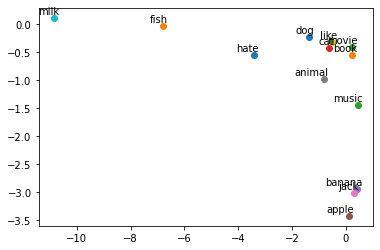

In [33]:
for i, label in enumerate(vocab):
    W, WT = model.parameters()
    x,y = float(W[i][0]), float(W[i][1])
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()